### Node Langgraph 
Node Langgraph is a powerful tool for building and managing language models using a graph-based approach. It allows developers to create complex language processing workflows by connecting various nodes that represent different language processing tasks.

In [1]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command , interrupt



In [ ]:
class State(TypedDict):
    mlist:List[str]
    

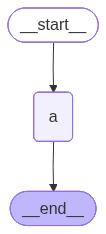

In [6]:
def node_a(state:State) -> State:
    """ node a """
    print(f"node a is receiving {state['mlist']}")
    note ="Hello world from node a"
    return (State(nlist = [note]))

builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_edge(START, "a")
builder.add_edge("a",END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))
#print(graph.get_graph().draw_mermaid())




In [7]:
initial_state = State(
    mlist = ["Hello Node, how are you"]
)
graph.invoke(initial_state)

node a is receiving ['Hello Node, how are you']


{'mlist': ['Hello Node, how are you']}

### Edges and Parallel Execution
Los Edges definen el flujo entre nodos en el grafo. Hay varios tipos:
1. EDGE NORMAL (secuencial)
2. CONDITIONAL EDGE (condicional)

### . Parallel Execution (Ejecución Paralela)
Ejecuta múltiples nodos simultáneamente para mejorar rendimiento
### Map Reduce
El patrón Map-Reduce divide trabajo en paralelo (Map) y luego combina resultados (Reduce):

```python
    summaries: Annotated[List[str], operator.add] (type, reducer)
```

### Regla principal
```sh
Cuando múltiples nodos escriben en la misma clave en paralelo, usa Annotated con un reductor adecuado (e.g., operator.add) para combinar resultados automáticamente.
```


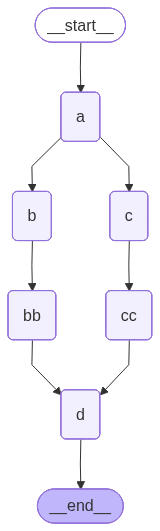

In [ ]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command , interrupt


class State(TypedDict):
    nlist: Annotated[List[str], operator.add]  # ← Reducer necesario
    
def node_a(state: State)-> State:
    """" node a """
    print(f"Adding 'A' to {state['nlist']}")
    return(State(nlist=["A"]))

def node_b(state:State) -> State:
    """ node b"""
    print(f"Add 'B' to {state['nlist']}")
    return(State(nlist=["B"]))

def node_c(state:State) -> State:
    """ node c"""
    print(f"Add 'C' to {state['nlist']}")
    return(State(nlist=["C"]))


def node_bb(state:State) -> State:
    """ node BB"""
    print(f"Add 'BB' to {state['nlist']}")
    return(State(nlist=["BB"]))


def node_cc(state:State) -> State:
    """ node CC"""
    print(f"Add 'CC' to {state['nlist']}")
    return(State(nlist=["CC"]))

def node_d(state:State) -> State:
    """ node d"""
    print(f"Add 'D' to {state['nlist']}")
    return(State(nlist=["D"]))


builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
builder.add_node("d", node_d)


builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "bb")
builder.add_edge("c", "cc")
builder.add_edge("bb", "d")
builder.add_edge("cc", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))




In [6]:
initial_state = State(
    nlist = ["Initial String"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String']
Addinb 'C' to ['Initial String', 'A']
Addinb 'B' to ['Initial String', 'A']
Addinb 'BB' to ['Initial String', 'A', 'B', 'C']
Addinb 'CC' to ['Initial String', 'A', 'B', 'C']
Addinb 'D' to ['Initial String', 'A', 'B', 'C', 'BB', 'CC']


{'nlist': ['Initial String', 'A', 'B', 'C', 'BB', 'CC', 'D']}

### Conditional Edges 
Los Conditional Edges permiten dirigir el flujo del grafo basado en condiciones específicas evaluadas en tiempo de ejecución. Esto es útil para crear rutas dinámicas dentro del grafo según los datos procesados.



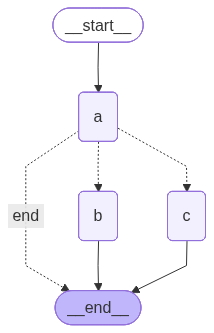

In [ ]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph

class State(TypedDict):
    nlist: Annotated[List[str], operator.add]  # ← Reducer necesario

def node_a(state: State):
    """node a"""
    print(f"Adding 'a' to {state['nlist']}")
    return {"nlist": ["a"]}  # ✅ Retornar dict, no State(...)

def node_b(state: State):
    """node b"""
    print(f"Adding 'b' to {state['nlist']}")
    return {"nlist": ["b"]}  # ✅ Retornar dict

def node_c(state: State):
    """node c"""
    print(f"Adding 'c' to {state['nlist']}")
    return {"nlist": ["c"]}  # ✅ Retornar dict

def conditional_edge(state: State) -> Literal["b", "c", "end"]:
    """Conditional Edge Example"""
    select = state["nlist"][-1]
    
    print(f"🔍 Evaluando último elemento: '{select}'")
    
    if select == "b":
        return "b"
    elif select == "c":
        return "c"
    elif select == "q":
        return "end"  # ✅ Usar string "end", no END directamente
    else:
        return "end"

# ✅ Builder FUERA de la función conditional_edge
builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

builder.add_edge(START, "a")
builder.add_conditional_edges(  # ✅ add_conditional_edges (plural)
    "a",
    conditional_edge,
    {
        "b": "b",
        "c": "c",
        "end": END  # ✅ Mapear string "end" a END
    }
)
builder.add_edge("b", END)
builder.add_edge("c", END)

graph = builder.compile()

# Visualizar
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
user_input = input("Enter a value (a, b, c, q): ")
input_state = State(
    nlist=[user_input]
)
graph.invoke(input_state)


Adding 'a' to ['a']
🔍 Evaluando último elemento: 'a'


{'nlist': ['a', 'a']}

In [ ]:
### Other form conditional desde el node

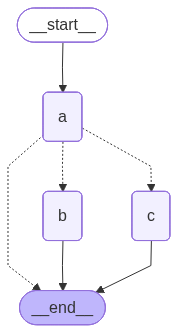

In [2]:
# 🔧 CÓDIGO CORREGIDO - COMMAND PATTERN

from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command  # ✅ IMPORTACIÓN AGREGADA

class State(TypedDict):
    nlist: Annotated[List[str], operator.add]  # ← Reducer necesario

def node_a(state: State) -> Command[Literal["b","c",END]]:
    """node a - Usa Command para decidir el siguiente nodo"""
    
    select = state["nlist"][-1]  # Último elemento
    print(f"🔍 Node A procesando: '{select}'")
    
    # Decidir siguiente nodo basado en el input
    if select == "b":
        next_node = "b"
        print("➡️ Dirigiendo a node_b")
    elif select == "c":
        next_node = "c"
        print("➡️ Dirigiendo a node_c")
    elif select == "q":
        next_node = END  # ✅ Usar string para END
        print("🏁 Terminando grafo")
    else:
        next_node = END  # ✅ Por defecto, terminar
        print("🏁 Input no reconocido, terminando")

    # ✅ SINTAXIS CORRECTA DE Command
    return Command(
        update={"nlist": [f"processed_{select}"]},  # ✅ Diccionario correcto
        goto=next_node
    )

def node_b(state: State):
    """node b"""
    print(f"🅱️ Node B - Adding 'b' to {state['nlist']}")
    return {"nlist": ["b"]}

def node_c(state: State):
    """node c"""
    print(f"🅲 Node C - Adding 'c' to {state['nlist']}")
    return {"nlist": ["c"]}

# 🏗️ CONSTRUIR EL GRAFO
builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)

# ✅ EDGES CORRECTOS
builder.add_edge(START, "a")
builder.add_edge("b", END)
builder.add_edge("c", END)

graph = builder.compile()

# Visualizar
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error generando imagen: {e}")
    print("Diagrama en texto:")
    print(graph.get_graph().draw_mermaid())

In [ ]:
while True:
    user = input('b, c, or q to quit: ')
    print(user)
    input_state = State(nlist =  [user])
    result = graph.invoke(input_state)
    print( result )
    if result['nlist'][-1] == "q":
        print("quit")
        break

b
🔍 Node A procesando: 'b'
➡️ Dirigiendo a node_b
🅱️ Node B - Adding 'b' to ['b', 'processed_b']
{'nlist': ['b', 'processed_b', 'b']}
c
🔍 Node A procesando: 'c'
➡️ Dirigiendo a node_c
🅲 Node C - Adding 'c' to ['c', 'processed_c']
{'nlist': ['c', 'processed_c', 'c']}
b
🔍 Node A procesando: 'b'
➡️ Dirigiendo a node_b
🅱️ Node B - Adding 'b' to ['b', 'processed_b']
{'nlist': ['b', 'processed_b', 'b']}
c
🔍 Node A procesando: 'c'
➡️ Dirigiendo a node_c
🅲 Node C - Adding 'c' to ['c', 'processed_c']
{'nlist': ['c', 'processed_c', 'c']}
a
🔍 Node A procesando: 'a'
🏁 Input no reconocido, terminando
{'nlist': ['a', 'processed_a']}
q
🔍 Node A procesando: 'q'
🏁 Terminando grafo
{'nlist': ['q', 'processed_q']}
q
🔍 Node A procesando: 'q'
🏁 Terminando grafo
{'nlist': ['q', 'processed_q']}
q
🔍 Node A procesando: 'q'
🏁 Terminando grafo
{'nlist': ['q', 'processed_q']}
q
🔍 Node A procesando: 'q'
🏁 Terminando grafo
{'nlist': ['q', 'processed_q']}

🔍 Node A procesando: ''
🏁 Input no reconocido, terminando
{'

### Memory checkpointer 
El Memory Checkpointer permite guardar y restaurar el estado de la memoria en puntos específicos del grafo. Esto es útil para mantener el contexto en flujos de trabajo complejos y para la recuperación ante fallos.

